<a href="https://colab.research.google.com/github/rahiakela/deep-learning-research-and-practice/blob/main/inside-deep-learing/04-recurrent-neural-networks/01_recurrent_neural_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Convolutional neural networks

Recurrent neural networks (RNNs) has concept of **weight sharing** where we reuse a layer in multiple locations. PyTorch handles the tricky math of learning correctly when reusing a layer.

<img src='images/1.png' width='600'/>



##Setup

In [ ]:
!wget https://github.com/EdwardRaff/Inside-Deep-Learning/raw/main/idlmam.py

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision 
from torchvision import transforms

from torch.utils.data import Dataset, DataLoader

from tqdm.autonotebook import tqdm

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

from sklearn.metrics import accuracy_score

from scipy.signal import convolve

import time

from idlmam import train_simple_network, set_seed, Flatten, weight_reset

In [3]:
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)

torch.backends.cudnn.deterministic=True
set_seed(42)

In [4]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

##Preparing dataset

Here, we will start exploring the ubiquitous MNIST dataset. 

It’s a collection of black-and-white images of the digits 0
through 9; each is 28 pixels wide and 28 pixels tall.

In [ ]:
# simply specify the ToTensor transform, which converts image into a tensor
mnist_data_train = torchvision.datasets.MNIST("./data", train=True, download=True, transform=transforms.ToTensor())
mnist_data_test = torchvision.datasets.MNIST("./data", train=False, download=True, transform=transforms.ToTensor())

In [6]:
mnist_train_loader = DataLoader(mnist_data_train, batch_size=64, shuffle=True)
mnist_test_loader = DataLoader(mnist_data_test, batch_size=64) 

##Weight sharing using MLP

In [7]:
# 28 * 28 images
D = 28 * 28

# Hidden layer size
n = 256

# How many channels are in the input?
C = 1

# How many classes are there?
classes = 10

Let's creates our regular model.

In [9]:
model_regular = nn.Sequential(
  Flatten(),
  nn.Linear(D, n),
  nn.Tanh(),
  nn.Linear(n, n),
  nn.Tanh(),
  nn.Linear(n, n),
  nn.Tanh(),
  nn.Linear(n, classes)
)

In [ ]:
loss_func = nn.CrossEntropyLoss()
regular_results = train_simple_network(model_regular,
                                       loss_func,
                                       mnist_train_loader,
                                       test_loader=mnist_test_loader,
                                       score_funcs={"Accuracy": accuracy_score}, 
                                       device=device,
                                       epochs=10)

Now, let’s pretend that this is a very large network—so large that we can’t fit the weights
for all three hidden layers.

But we really want a network with
three hidden layers. One option is to share the weights between some of the layers. We
can do this mathematically by simply replacing `h3` with `h2`, which is the same as defining
one object and reusing that object twice in our definition.

This is weight sharing, reusing the weights of a layer. It’s called
this because we can pretend the two different usages of $W^{(h_2)}$ are different layers in
the network that share the same weights. 

How do we implement this in PyTorch? 

It’s simple. If we think of that linear layer as an object, we reuse the layer object. Everything
else works exactly the same.

In [12]:
# Creates the layer of weights for our network that we plan to share
h_2 = nn.Linear(n, n)

model_shared = nn.Sequential(
  Flatten(),
  nn.Linear(D, n),
  nn.Tanh(),
  h_2,
  nn.Tanh(),
  h_2,
  nn.Tanh(),
  nn.Linear(n, classes)
)

It’s a very objectoriented
design: we create an object, and the object is used in two places.

In [ ]:
shared_results = train_simple_network(model_shared,
                                       loss_func,
                                       mnist_train_loader,
                                       test_loader=mnist_test_loader,
                                       score_funcs={"Accuracy": accuracy_score}, 
                                       device=device,
                                       epochs=10)

We can plot the validation accuracy of both to see
what PyTorch really learn with shared weights.

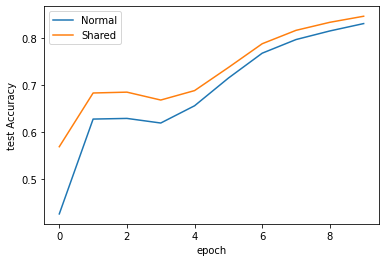

In [14]:
sns.lineplot(x='epoch', y='test Accuracy', data=regular_results, label='Normal')
sns.lineplot(x='epoch', y='test Accuracy', data=shared_results, label='Shared')

Using weight sharing doesn’t take any longer to train, and we don’t lose any accuracy.

We do get a nice benefit of slightly reduced memory, but what
we have done here is rarely used. Better approaches exist to reduce memory usage, and
the purpose of this problem was just to demonstrate the weight sharing. 

We care about
weight sharing because it is the foundation for creating and training RNNs.

##Weight sharing over time